# Predicting Diabetes

## Background: 
Diabetes is one of the most common and most expensive chronic diseases worldwide. In 2004 it was estimated that in the US alone, approximately 5 million people unknowingly had the disease while another 13 million were aware of their diagnosis. 

## Problem Statement:  
Early detection of the disease can help reduce the risk of serious life changing complications such as premature heart disease, stroke, blindness, limb amputations, and kidney failure.  Models that can help predict an individual with diabetes could be a useful tool to support a physician’s decision-making process when working with patients. It could also be leveraged to screen populations of patient data to identify patients most likely to have undiagnosed diabetes and intervene with further testing and monitoring. This can be framed as a binary classification problem to separate those who will vs. those who will not develop diabetes.

## Dataset

> **Citation for the data:** The Pima Indian Diabetes Dataset used originally came from this paper:
** Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press. Now available for download via Kaggle [here](https://www.kaggle.com/uciml/pima-indians-diabetes-database).

* Note that because the dataset is hosted on Kaggle, it can be downloaded by generating an API token for your user id and installing the Kaggle-cli in your notebook environment. 
* For simplicity in this notebook, I downloaded and extracted the data on my local machine and then uploaded it into my notebook environment. The file 'diabetes.csv' is the unmodified extracted download file from Kaggle.

## Baseline / Benchmark
I am interested in comparing my results to that of the original paper that was written about the Pima Indian Dataset which is located here: [Using the ADAP Learning Algorithm to Forecast the Onset of Diabetes Mellitus](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2245318/). In this paper, the sensitivity and specificity achieved was 76%. The original paper also shows the ROC curve which is what I'm intending to compare to my results.

## Loading the data

In [1]:
# confirm that the file is accessible
!ls -al data/raw/diabetes.csv

-rw-rw-r-- 1 ec2-user ec2-user 23873 Aug  5 06:00 data/raw/diabetes.csv


In [15]:
%matplotlib inline

# Load the data into a dataframe
import pandas as pd
import os

source_data_dir = 'data/raw'
clean_data_dir = 'data/train-test'

diabetes_df = pd.read_csv(os.path.join(source_data_dir, 'diabetes.csv'))
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [16]:
# Look at the data to get an idea of what it contains.
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


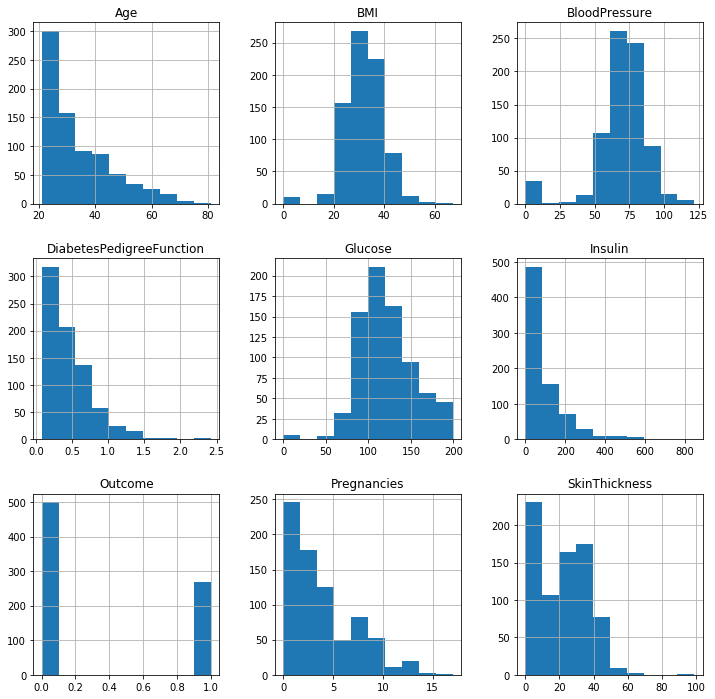

In [32]:
# look at distribution of features by the two outcome classes

_ = diabetes_df.hist(figsize=(12,12))

Visual inspection of a summary of the data shows that there are a number of features with minimum values of 0. These are worth exploring in more detail. It does not look like the data contains any NaN / NA values.

## Review of missing feature values:

There are missing variable in the dataset although they're not all immediately apparent because they are coded as zeros rather than NaN or NA values. Because zero can be a valid measurement for some of the variables, we'll need to consider them one by one:

**Pregnancies** - 0 can be a valid measurement

**Glucose:** - 0 is unlikely to be a valid measurement

**Blood Pressure:** - 0 is unlikely to be a valid measurement

**Skin Thickness:** - 0 is unlikely to be a valid measurement

**Insulin:** - 0 is unlikely to be a valid measurement

**BMI:** - 0 is unlikely to be a valid measurement

**DiabetesPedigreeFunction:** - 0 can be a valid measurement score representing hereditary risk of diabetes based on familial and closeness of genetic relationships. 

In [18]:
# look at missing values -- indicated with a zero

print("Counts of zero as value:")
print("\t Glucose: {}".format(sum(diabetes_df.Glucose == 0)))
print("\t Blood Pressure: {}".format(sum(diabetes_df.BloodPressure == 0)))
print("\t SkinThickness: {}".format(sum(diabetes_df.SkinThickness == 0)))
print("\t Insulin: {}".format(sum(diabetes_df.Insulin == 0)))
print("\t BMI: {}".format(sum(diabetes_df.BMI == 0)))

print("\t Glucose + BloodPressure + BMI all 0: {}".format(sum((diabetes_df.Glucose == 0) &
                                                          (diabetes_df.BloodPressure == 0) &
                                                          (diabetes_df.BMI == 0))))

Counts of zero as value:
	 Glucose: 5
	 Blood Pressure: 35
	 SkinThickness: 227
	 Insulin: 374
	 BMI: 11
	 Glucose + BloodPressure + BMI all 0: 0


Because the data are on a variety of scales, it is worth scaling features. While a model like a decision tree should be able to work around the variation in scales, scaling the features gives a little more flexibility in choosing other model architectures.

## Preprocessing

### Feature Scaling

In [21]:
# Preprocesing - Feature Scaling

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
    
# separate features from labels
labels = diabetes_df.Outcome
data = diabetes_df.drop(columns = ['Outcome'])

# do basic Min/Max 0-1 scaling of features
cols = data.columns
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(X=data, y=None), columns=cols)

# visually inspect to look for anything unexpected
data.head()

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,0.483333
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,0.166667
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,0.183333
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,0.000000
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,0.200000


### Train/Validation/Test Splits

In [22]:
# Preprocessing - Train/Validation/Test Splits

random_state = 27

# split into train, valtest splits, putting 80% of data into training
X_train, X_valtest, y_train, y_valtest = train_test_split(data, labels, 
                                                          random_state = random_state,
                                                          test_size = .2)

# split remaining 20% of data in valtest equally so 10% validation / 10% testing
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest,
                                                random_state = random_state,
                                                test_size = .5)

# print sizes to make sure we got what we expected
print("Training data shape: {} Training label shape: {}".format(X_train.shape, y_train.shape))
print("Validation data shape: {} Validation label shape: {}".format(X_val.shape, y_val.shape))
print("Testing data shape: {} Testing label shape: {}".format(X_test.shape, y_test.shape))

Training data shape: (614, 8) Training label shape: (614,)
Validation data shape: (77, 8) Validation label shape: (77,)
Testing data shape: (77, 8) Testing label shape: (77,)


### Store prepared data

In [23]:
# structure data for processing by training model and store as csv
def make_csv(x, y, filename, data_dir):
    '''Merges features and labels and converts them into one csv file with labels in the first column.
       :param x: Data features
       :param y: Data labels
       :param file_name: Name of csv file, ex. 'train.csv'
       :param data_dir: The directory where files will be saved
       '''

    # make data dir, if it does not exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    df_X = pd.DataFrame(x)
    df_y = pd.DataFrame(y)
    
    df_all = pd.concat([df_y,df_X], axis=1)
    
    df_all.to_csv(data_dir + '/' + filename, index = False, header=False)

    # nothing is returned, but a print statement indicates that the function has run
    print('Path created: '+str(data_dir)+'/'+str(filename))

In [24]:
make_csv(X_train, y_train, 'train.csv', clean_data_dir)
make_csv(X_val, y_val, 'validation.csv', clean_data_dir)
make_csv(X_test, y_test, 'test.csv', clean_data_dir)

Path created: data/train-test/train.csv
Path created: data/train-test/validation.csv
Path created: data/train-test/test.csv


### Upload data to S3

In [25]:
# copy data to s3
import boto3
import sagemaker

# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

# set prefix, a descriptive name for a directory  
prefix = 'capstone'

# upload all data to S3
input_data = sagemaker_session.upload_data(path=clean_data_dir, bucket=bucket, key_prefix=prefix)
print(input_data)

s3://sagemaker-us-west-2-501454055284/capstone


## Build & Train Model

### Model Selection

I am going to use apply the XGBoost algorithm to the data to predict those cases where diabetes onset will occur. The XGBoost algorithm is currently a widely successful algorithm on a variety of problems. In many cases it can yield performance close to or on par with deep learning models. It is also robust enough to handle the class imbalance in the dataset. Furthermore AWS SageMaker has a pre-built container for this algorithm which simplifies the development of an initial model without needing to implement a custom container for a deep learning approach like TensorFlow or PyTorch. I'm favoring the most straightforward approach first and can come back and explore those models later if needed.

In [26]:
# build xgBoost estimator
# As stated above, we use this utility method to construct the image name for the training container.
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=2, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance to use for training
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=sagemaker_session) # The current SageMaker session

In [27]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='binary:logistic',
                        early_stopping_rounds=10,
                        num_round=500)

In [28]:

from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb, # The estimator object to use as the basis for the training jobs.
                                               objective_metric_name = 'validation:auc', # The metric used to compare trained models.
                                               objective_type = 'Maximize', # Whether we wish to minimize or maximize the metric.
                                               max_jobs = 10, # The total number of models to train
                                               max_parallel_jobs = 5, # The number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(3, 12),
                                                    'eta'      : ContinuousParameter(0.05, 0.5),
                                                    'min_child_weight': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(0, 10),
                                               })

In [29]:
# This is a wrapper around the location of our train and validation data, to make sure that SageMaker
# knows our data is in csv format.

train_file_path = os.path.join(input_data, 'train.csv')
s3_input_train = sagemaker.s3_input(s3_data=train_file_path, content_type='csv')

val_file_path = os.path.join(input_data, 'validation.csv')
s3_input_val = sagemaker.s3_input(s3_data=val_file_path, content_type='csv')

#xgb.fit({'train': s3_input_train, 'validation': s3_input_val})
xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_val})
xgb_hyperparameter_tuner.wait()

..............................................................................................................................................................................!


## Deploy Model for Testing

Take the best performing model from the model search and deploy it as an endpoint for us to test against.

In [33]:
%%time

xgb_best_model = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())
# deploy model for testing
predictor = xgb_best_model.deploy(initial_instance_count=1,
                                  instance_type = 'ml.t2.medium')

2019-08-20 05:38:05 Starting - Preparing the instances for training
2019-08-20 05:38:05 Downloading - Downloading input data
2019-08-20 05:38:05 Training - Training image download completed. Training in progress.
2019-08-20 05:38:05 Uploading - Uploading generated training model
2019-08-20 05:38:05 Completed - Training job completedArguments: train
[2019-08-20:05:35:41:INFO] Running distributed xgboost training.
Arguments: train
[2019-08-20:05:35:45:INFO] Running distributed xgboost training.
[2019-08-20:05:35:48:INFO] Number of hosts: 2, master IP address: 10.0.80.227, host IP address: 10.0.80.227.
[2019-08-20:05:35:48:INFO] Finished Yarn configuration files setup.

[2019-08-20:05:35:48:INFO] Number of hosts: 2, master IP address: 10.0.80.227, host IP address: 10.0.115.200.
[2019-08-20:05:35:48:INFO] Finished Yarn configuration files setup.

starting datanode, logging to /opt/amazon/hadoop/logs/hadoop--datanode-ip-10-0-115-200.us-west-2.compute.internal.out
starting namenode, logging 

Look at hyperparameters of best performing model. This is important for anyone who may want to reproduce these results without the need for searching for a model.

In [34]:
xgb_best_model.hyperparameters()

{'_tuning_objective_metric': 'validation:auc',
 'early_stopping_rounds': '10',
 'eta': '0.24407035903048974',
 'gamma': '0.7534195623775507',
 'max_depth': '3',
 'min_child_weight': '2',
 'num_round': '500',
 'objective': 'binary:logistic',
 'subsample': '0.8943262465581064'}

## Predict from the test data

In [35]:
# We need to tell the endpoint what format the data we are sending is in
from sagemaker.predictor import csv_serializer
import numpy as np
predictor.content_type = 'text/csv'
predictor.serializer = csv_serializer

y_preds = predictor.predict(X_test.values).decode('utf-8')

# predictions is currently a comma delimited string and so we would like to break it up
# as a numpy array.
y_preds = np.fromstring(y_preds, sep=',')

# make sure the right number of labels are returned
assert len(y_preds)==len(y_test), 'Unexpected number of predictions.'
print('Correct number of results returned.')

Correct number of results returned.


## Clean up endpoint

In [36]:
# clean up and summarize
predictor.delete_endpoint()

## Evaluate Model Performance

Based on feedback of proposal review, I've looked at using accuracy vs. AUC-ROC and have opted for AUC-ROC as being better suited to measuring the performance of the model.

In [4]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

y_preds_ints = [round(num) for num in y_preds.squeeze()]

print(classification_report(y_test, y_preds_ints, labels = [0,1]))
print("ROC_AUC_Score: {}".format(roc_auc_score(y_test, y_preds)))
print("Accuracy Score: {}".format(accuracy_score(y_test, y_preds_ints)))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84        55
           1       0.60      0.55      0.57        22

   micro avg       0.77      0.77      0.77        77
   macro avg       0.71      0.70      0.71        77
weighted avg       0.76      0.77      0.76        77

ROC_AUC_Score: 0.8458677685950413
Accuracy Score: 0.7662337662337663


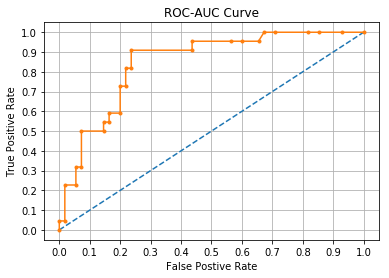

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, y_preds)

plt.figure()
plt.plot([0,1],[0,1], linestyle='--')

# plot the roc curve for the model
plt.plot(fpr, tpr, marker = '.')
plt.title("ROC-AUC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Postive Rate")
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.grid(True)

# show the plot
plt.show()